In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

import dqn_agent
#from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
#from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

In [2]:
env_name = 'CartPole-v1'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100,)

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

In [3]:
env = suite_gym.load(env_name)

In [4]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=1)


In [5]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Network

In [6]:
from tf_agents.specs import tensor_spec

class DDQN(tf.keras.Model):
    def __init__(self, input_tensor_spec, state_spec, name="DDQN"):
        super(DDQN, self).__init__()
        
        self._input_tensor_spec = input_tensor_spec
        self._state_spec = ()
        self.init_state_spec = state_spec
        
        hidden_units = 32
        action_spec = tf.nest.flatten(state_spec)[0]
        num_actions = action_spec.maximum - action_spec.minimum + 1
        
        # Shared layers
        self._shared1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
     
        self._shared2 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')

        # Learn advantage
        self._adv1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
        self._adv2 = tf.keras.layers.Dense(num_actions, 
                         activation='linear', 
                         kernel_initializer='he_uniform')
        self._adv3 = tf.keras.layers.Lambda(lambda a: a - tf.keras.backend.mean(a, axis=1, keepdims=True), 
                                            output_shape=(num_actions,))
        
        # Learn value
        self._value1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
        self._value2 = tf.keras.layers.Dense(1, 
                         activation='linear', 
                         kernel_initializer='he_uniform')
        
        # Combine into Q
        self._q_out = tf.keras.layers.Add()

    def call(self, observation, step_type=None, network_state=()):
        shared = self._shared1(observation)
        shared = self._shared2(shared)
        adv = self._adv1(shared)
        adv = self._adv2(adv)
        adv = self._adv3(adv)
        value = self._value1(shared)
        value = self._value2(shared)
        q_out = self._q_out([adv, value])
        return q_out, network_state
    
    def copy(self, name):
        print("copy override")
        return type(self)(self._input_tensor_spec, self.init_state_spec, name)
    
    @property
    def state_spec(self):
        return self._state_spec

    def _build(self):
        if not self.built and self.input_tensor_spec is not None:
            random_input = tensor_spec.sample_spec_nest(self.input_tensor_spec, outer_dims=(1,))
            #step_type = tf.expand_dims(time_step.StepType.FIRST, 0)
            self.__call__(random_input, None, None)

    @property
    def input_tensor_spec(self):
        return self._input_tensor_spec

    @property
    def variables(self):
        try:
            self._build()
        except ValueError as e:
            traceback = sys.exc_info()[2]
            six.reraise(
                ValueError, "Failed to call build on the network when accessing "
                "variables. Message: {!r}.".format(e), traceback)
        return self.weights


In [7]:
q_net = DDQN(
    train_env.observation_spec(),
    train_env.action_spec())

#q_net = q_network.QNetwork(
#    train_env.observation_spec(),
#    train_env.action_spec(),
#    fc_layer_params=fc_layer_params)

# Agent

In [8]:
import gin
import collections
from tf_agents.agents import tf_agent
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import q_policy
from tf_agents.utils import nest_utils


def element_wise_squared_loss(x, y):
    return tf.compat.v1.losses.mean_squared_error(
      x, y, reduction=tf.compat.v1.losses.Reduction.NONE)


def element_wise_huber_loss(x, y):
    return tf.compat.v1.losses.huber_loss(
      x, y, reduction=tf.compat.v1.losses.Reduction.NONE)


def compute_td_targets(next_q_values, rewards, discounts):
    return tf.stop_gradient(rewards + discounts * next_q_values)


class DqnLossInfo(collections.namedtuple('DqnLossInfo',
                                         ('td_loss', 'td_error'))):
    pass

@gin.configurable
class DqnAgent(tf_agent.TFAgent):
    def __init__(
      self,
      time_step_spec,
      action_spec,
      q_network,
      optimizer,
      epsilon_greedy=0.1,
      n_step_update=1,
      boltzmann_temperature=None,
      emit_log_probability=False,
      # Params for target network updates
      target_update_tau=1.0,
      target_update_period=1,
      # Params for training.
      td_errors_loss_fn=None,
      gamma=1.0,
      reward_scale_factor=1.0,
      gradient_clipping=None,
      # Params for debugging
      debug_summaries=False,
      summarize_grads_and_vars=False,
      train_step_counter=None,
      name=None):
        tf.Module.__init__(self, name=name)

        flat_action_spec = tf.nest.flatten(action_spec)
        self._num_actions = [
            spec.maximum - spec.minimum + 1 for spec in flat_action_spec
        ]

        # TODO(oars): Get DQN working with more than one dim in the actions.
        if len(flat_action_spec) > 1 or flat_action_spec[0].shape.ndims > 1:
            raise ValueError('Only one dimensional actions are supported now.')

        if not all(spec.minimum == 0 for spec in flat_action_spec):
            raise ValueError(
              'Action specs should have minimum of 0, but saw: {0}'.format(
                  [spec.minimum for spec in flat_action_spec]))

        if epsilon_greedy is not None and boltzmann_temperature is not None:
            raise ValueError(
              'Configured both epsilon_greedy value {} and temperature {}, '
              'however only one of them can be used for exploration.'.format(
                  epsilon_greedy, boltzmann_temperature))

        self._q_network = q_network
        self._target_q_network = self._q_network.copy(name='TargetQNetwork')
        self._epsilon_greedy = epsilon_greedy
        self._n_step_update = n_step_update
        self._boltzmann_temperature = boltzmann_temperature
        self._optimizer = optimizer
        self._td_errors_loss_fn = td_errors_loss_fn or element_wise_huber_loss
        self._gamma = gamma
        self._reward_scale_factor = reward_scale_factor
        self._gradient_clipping = gradient_clipping
        self._update_target = self._get_target_updater(
            target_update_tau, target_update_period)

        policy = q_policy.QPolicy(
            time_step_spec,
            action_spec,
            q_network=self._q_network,
            emit_log_probability=emit_log_probability)

        if boltzmann_temperature is not None:
            print("collect policy is boltzmann")
            collect_policy = boltzmann_policy.BoltzmannPolicy(
              policy, temperature=self._boltzmann_temperature)
        else:
            print ("collect policy is e-greedy")
            collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
              policy, epsilon=self._epsilon_greedy)
        policy = greedy_policy.GreedyPolicy(policy)

        if q_network.state_spec and n_step_update != 1:
            raise NotImplementedError(
              'DqnAgent does not currently support n-step updates with stateful '
              'networks (i.e., RNNs), but n_step_update = {}'.format(n_step_update))

        train_sequence_length = (
            n_step_update + 1 if not q_network.state_spec else None)

        super(DqnAgent, self).__init__(
            time_step_spec,
            action_spec,
            policy,
            collect_policy,
            train_sequence_length=train_sequence_length,
            debug_summaries=debug_summaries,
            summarize_grads_and_vars=summarize_grads_and_vars,
            train_step_counter=train_step_counter)

    def _initialize(self):
        common.soft_variables_update(
            self._q_network.variables, self._target_q_network.variables, tau=1.0)

    def _get_target_updater(self, tau=1.0, period=1):
        with tf.name_scope('update_targets'):

            def update():
                return common.soft_variables_update(
                self._q_network.variables, self._target_q_network.variables, tau)

            return common.Periodically(update, period, 'periodic_update_targets')

    def _experience_to_transitions(self, experience):
        transitions = trajectory.to_transition(experience)

        # Remove time dim if we are not using a recurrent network.
        if not self._q_network.state_spec:
            print("no state spec, map structure")
            transitions = tf.nest.map_structure(lambda x: tf.squeeze(x, [1]),
                                          transitions)

        time_steps, policy_steps, next_time_steps = transitions
        actions = policy_steps.action
        return time_steps, actions, next_time_steps

    # Use @common.function in graph mode or for speeding up.
    def _train(self, experience, weights):
        with tf.GradientTape() as tape:
              loss_info = self._loss(
                  experience,
                  td_errors_loss_fn=self._td_errors_loss_fn,
                  gamma=self._gamma,
                  reward_scale_factor=self._reward_scale_factor,
                  weights=weights)
        tf.debugging.check_numerics(loss_info[0], 'Loss is inf or nan')
        variables_to_train = self._q_network.trainable_weights
        assert list(variables_to_train), "No variables in the agent's q_network."
        grads = tape.gradient(loss_info.loss, variables_to_train)
        # Tuple is used for py3, where zip is a generator producing values once.
        grads_and_vars = tuple(zip(grads, variables_to_train))
        if self._gradient_clipping is not None:
            print("gradient clipping enabled")
            grads_and_vars = eager_utils.clip_gradient_norms(grads_and_vars,
                                                       self._gradient_clipping)

        if self._summarize_grads_and_vars:
            eager_utils.add_variables_summaries(grads_and_vars,
                                          self.train_step_counter)
            eager_utils.add_gradients_summaries(grads_and_vars,
                                          self.train_step_counter)

        self._optimizer.apply_gradients(grads_and_vars,
                                    global_step=self.train_step_counter)

        self._update_target()

        return loss_info

    def _loss(self,
            experience,
            td_errors_loss_fn=element_wise_huber_loss,
            gamma=1.0,
            reward_scale_factor=1.0,
            weights=None):
        # Check that `experience` includes two outer dimensions [B, T, ...]. This
        # method requires a time dimension to compute the loss properly.
        self._check_trajectory_dimensions(experience)

        time_steps, actions, next_time_steps = self._experience_to_transitions(experience)

        with tf.name_scope('loss'):
            actions = tf.nest.flatten(actions)[0]
            q_values, _ = self._q_network(time_steps.observation,
                                    time_steps.step_type)

            # Handle action_spec.shape=(), and shape=(1,) by using the
            # multi_dim_actions param.
            multi_dim_actions = tf.nest.flatten(self._action_spec)[0].shape.ndims > 0
            print("multi_dim_actions={}".format(multi_dim_actions))
            q_values = common.index_with_actions(
                q_values,
                tf.cast(actions, dtype=tf.int32),
                multi_dim_actions=multi_dim_actions)

            next_q_values = self._compute_next_q_values(next_time_steps)

            td_targets = compute_td_targets(
                next_q_values,
                rewards=reward_scale_factor * next_time_steps.reward,
                discounts=gamma * next_time_steps.discount)

            valid_mask = tf.cast(~time_steps.is_last(), tf.float32)
            td_error = valid_mask * (td_targets - q_values)

            td_loss = valid_mask * td_errors_loss_fn(td_targets, q_values)

            if nest_utils.is_batched_nested_tensors(time_steps, self.time_step_spec, num_outer_dims=2):
                # Do a sum over the time dimension.
                print("is nested")
                td_loss = tf.reduce_sum(input_tensor=td_loss, axis=1)

            if weights is not None:
                print("has weights")
                td_loss *= weights

            # Average across the elements of the batch.
            # Note: We use an element wise loss above to ensure each element is always
            #   weighted by 1/N where N is the batch size, even when some of the
            #   weights are zero due to boundary transitions. Weighting by 1/K where K
            #   is the actual number of non-zero weight would artificially increase
            #   their contribution in the loss. Think about what would happen as
            #   the number of boundary samples increases.
            loss = tf.reduce_mean(input_tensor=td_loss)

            return tf_agent.LossInfo(loss, DqnLossInfo(td_loss=td_loss,
                                                 td_error=td_error))

    def _compute_next_q_values(self, next_time_steps):
        next_target_q_values, _ = self._target_q_network(
        next_time_steps.observation, next_time_steps.step_type)
        # Reduce_max below assumes q_values are [BxF] or [BxTxF]
        assert next_target_q_values.shape.ndims in [2, 3]
        return tf.reduce_max(input_tensor=next_target_q_values, axis=-1)


In [9]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

dqn_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter)
dqn_agent.initialize()

copy override
collect policy is e-greedy


In [10]:
eval_policy = dqn_agent.policy
collect_policy = dqn_agent.collect_policy

In [11]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [12]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [13]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=dqn_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [14]:
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

In [15]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [16]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
dqn_agent.train = common.function(dqn_agent.train)

# Reset the train step
dqn_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, dqn_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, dqn_agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = dqn_agent.train(experience)

    step = dqn_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, dqn_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


W0711 09:03:55.514138 4614600128 deprecation.py:323] From /Users/jwatts/TensorflowProjects/lib/python3.7/site-packages/tf_agents/policies/epsilon_greedy_policy.py:96: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


td_errors_loss_fn=<function element_wise_squared_loss at 0x139f4ae18>
_n_step_update=1
no state spec, map structure
multi_dim_actions=False
reward_scale_factor=1.0; gamma=1.0
td_errors_loss_fn=<function element_wise_squared_loss at 0x139f4ae18>
_n_step_update=1
no state spec, map structure
multi_dim_actions=False
reward_scale_factor=1.0; gamma=1.0
step = 200: loss = 70.516845703125
step = 400: loss = 31.066225051879883
step = 600: loss = 49.29338836669922
step = 800: loss = 93.052490234375
step = 1000: loss = 38.62739181518555
step = 1000: Average Return = 500.0
step = 1200: loss = 97.64010620117188
step = 1400: loss = 216.76687622070312
step = 1600: loss = 847.4637451171875
step = 1800: loss = 7704.18603515625
step = 2000: loss = 2600.293701171875
step = 2000: Average Return = 60.5
step = 2200: loss = 6456.88671875
step = 2400: loss = 1501.7064208984375
step = 2600: loss = 18047.22265625
step = 2800: loss = 1306.30322265625
step = 3000: loss = 1718.62548828125
step = 3000: Average Ret

(35.16499919891358, 550)

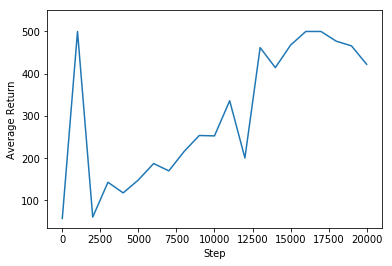

In [17]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [18]:
time_step = eval_env.reset()
while not time_step.is_last():
    action_step = dqn_agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    eval_py_env.render()